In [1]:
from tqdm import tqdm
import torch 

In [2]:
from hydra import initialize, compose

initialize(config_path='configs')

from src.configuration import register_configs

register_configs()

cfg = compose(overrides=['+experiment=core_classification_notebook'])

from omegaconf import OmegaConf
OmegaConf.resolve(cfg)

from hydra.utils import instantiate

from rich import print as pprint
pprint(OmegaConf.to_object(cfg))

/tmp/ipykernel_9478/2095799912.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='configs')
/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  stdout_func(


{
    'patch_dm': ExactPatchDMConfig(
        _target_='src.lightning.datamodules.exact_datamodule.PatchDataModuleForSupervisedLear
ning',
        root='/home/mgilani/data/Exact/Exact',
        loader_config=LoaderConfig(
            batch_size=32,
            num_workers=20,
            balance_classes_train=True,
            train_strategy_ddp=False
        ),
        minimum_involvement=0.4,
        splits=SplitsConfig(
            _target_='src.data.exact.splits.Splits',
            cohort_specifier=['CRCEO', 'JH', 'PCC', 'PMCC', 'UVA'],
            train_val_split_seed=2,
            train_val_ratio=0.1,
            undersample_benign_train=True,
            undersample_benign_eval=True,
            benign_cores_selection_seed=0,
            merge_train_centers=True,
            merge_val_centers=True,
            merge_test_centers=True
        ),
        patch_view_config=PatchViewConfig(
            patch_size=[5, 5],
            patch_strides=[1, 1],
            subpatch_size=[1, 1],
            needle_region_only=True,
            prostate_region_only=False,
            prostate_intersection_threshold=0.9,
            needle_intersection_threshold=0.6
        ),
        patch_transform_train=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                truncate=True
            ),
            tensor_transform=None,
            us_augmentation=None,
            out_size=[256, 256]
        ),
        patch_transform_eval=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                truncate=True
            ),
            tensor_transform=None,
            us_augmentation=None,
            out_size=[256, 256]
        )
    ),
    'core_dm': ExactPatchDMConfig(
        _target_='src.lightning.datamodules.exact_datamodule.PatchesConcatenatedFromCoresData
Module',
        root='/home/mgilani/data/Exact/Exact',
        loader_config=LoaderConfig(
            batch_size=1,
            num_workers=20,
            balance_classes_train=True,
            train_strategy_ddp=False
        ),
        minimum_involvement=0.4,
        splits=SplitsConfig(
            _target_='src.data.exact.splits.Splits',
            cohort_specifier=['CRCEO', 'JH', 'PCC', 'PMCC', 'UVA'],
            train_val_split_seed=2,
            train_val_ratio=0.1,
            undersample_benign_train=True,
            undersample_benign_eval=True,
            benign_cores_selection_seed=0,
            merge_train_centers=True,
            merge_val_centers=True,
            merge_test_centers=True
        ),
        patch_view_config=PatchViewConfig(
            patch_size=[5, 5],
            patch_strides=[1, 1],
            subpatch_size=[1, 1],
            needle_region_only=True,
            prostate_region_only=False,
            prostate_intersection_threshold=0.9,
            needle_intersection_threshold=0.6
        ),
        patch_transform_train=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                truncate=True
            ),
            tensor_transform=None,
            us_augmentation=None,
            out_size=[256, 256]
        ),
        patch_transform_eval=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                truncate=True
            ),
            tensor_transform=Non

In [3]:
from pytorch_lightning import seed_everything
seed_everything(0)

Global seed set to 0


0

In [4]:
#cfg.patch_dm.splits.cohort_specifier = ['UVA600']
#cfg.core_dm.splits.cohort_specifier = ['UVA600']

patch_dm = instantiate(cfg.patch_dm)
core_dm = instantiate(cfg.core_dm)

In [5]:
patch_dm.setup()

Indexing Patches: 100%|██████████| 315/315 [00:08<00:00, 36.35it/s]


In [6]:
core_dm.setup()

Loading Patch Views: 100%|██████████| 315/315 [00:08<00:00, 36.64it/s]


## Experiment 1 with Frozen backbone

First, test the linear evaluation:

In [7]:

from src.modeling.registry import create_model, list_models
from src.utils.metrics import ClassificationOutputCollector


pretrained_vicreg = create_model('vicreg_resnet_10_crops_split_seed_2')
pretrained_vicreg.eval().to(cfg.device)

collector = ClassificationOutputCollector()

for batch in tqdm(patch_dm.test_dataloader()): 
    patch, pos, label, metadata = batch

    with torch.inference_mode(): 
        feats = pretrained_vicreg.get_features(patch.to(cfg.device))
        logits = pretrained_vicreg.linear_layer(feats)
        preds = logits.softmax(-1)

    collector.collect_batch({
        'preds': preds, 
        'pos': pos, 
        'labels': label, 
        **metadata
    })

out = collector.compute()

100%|██████████| 542/542 [00:12<00:00, 43.37it/s]


In [8]:
from typing import Callable
from src.utils.metrics import patch_out_to_core_out, group_output_by_centers
from importlib import reload
import src.utils.metrics
from torchmetrics.functional import auroc, accuracy

def base_metrics(out): 
    preds = out['preds']
    labels = out['labels']
    return {'auroc': auroc(preds, labels, num_classes=2).item(), 'macro_acc': accuracy(preds, labels, average='macro', num_classes=2).item()}

core_out = patch_out_to_core_out(out)

def add_prefix(dict, prefix, sep='_'): 
    return {f'{prefix}{sep}{k}': v for k, v in dict.items()}

def compute_center_and_macro_metrics(out, base_metrics: Callable):
    metrics = {}
    micro_metrics = base_metrics(out)
    metric_keys = micro_metrics.keys()
    metrics.update(
        add_prefix(micro_metrics, 'micro_avg')
    )
    macro_avg_tracker = {}
    for center, out_ in group_output_by_centers(out).items(): 
        metrics_for_center = base_metrics(out_)
        for k, v in metrics_for_center.items(): 
            macro_avg_tracker.setdefault(k, []).append(v)
        metrics.update(add_prefix(metrics_for_center, center))

    for k, v in macro_avg_tracker.items(): 
        metrics[f'macro_avg_{k}'] = sum(v)/len(v)

    return metrics

def patch_and_core_metrics(patch_out, base_metrics: Callable): 
    metrics = {}
    metrics.update(add_prefix(compute_center_and_macro_metrics(out, base_metrics), 'patch'))
    core_out = patch_out_to_core_out(out)
    metrics.update(add_prefix(compute_center_and_macro_metrics(core_out, base_metrics), 'core'))
    return metrics 

patch_and_core_metrics(out, base_metrics)

{'patch_micro_avg_auroc': 0.6607375144958496,
 'patch_micro_avg_macro_acc': 0.6111615896224976,
 'patch_CRCEO_auroc': 0.6598196029663086,
 'patch_CRCEO_macro_acc': 0.601038932800293,
 'patch_JH_auroc': 0.5631171464920044,
 'patch_JH_macro_acc': 0.5391233563423157,
 'patch_PCC_auroc': 0.6787072420120239,
 'patch_PCC_macro_acc': 0.6273190975189209,
 'patch_PMCC_auroc': 0.619788646697998,
 'patch_PMCC_macro_acc': 0.5795862078666687,
 'patch_UVA_auroc': 0.7281572818756104,
 'patch_UVA_macro_acc': 0.6616966724395752,
 'patch_macro_avg_auroc': 0.6499179840087891,
 'patch_macro_avg_macro_acc': 0.6017528533935547,
 'core_micro_avg_auroc': 0.7957892417907715,
 'core_micro_avg_macro_acc': 0.7224701046943665,
 'core_CRCEO_auroc': 0.8380951881408691,
 'core_CRCEO_macro_acc': 0.788095235824585,
 'core_JH_auroc': 0.6071428060531616,
 'core_JH_macro_acc': 0.5892857313156128,
 'core_PCC_auroc': 0.7973760962486267,
 'core_PCC_macro_acc': 0.706632673740387,
 'core_PMCC_auroc': 0.7986207008361816,
 'core

In [9]:
from src.modeling.pca import TorchPCA
pca = TorchPCA(out_features=64)

all_train_patch_feats = [] 
for patch, *_ in tqdm(patch_dm.train_dataloader()): 
    patch = patch.to(cfg.device)
    with torch.no_grad():
        feats = pretrained_vicreg.get_features(patch)
    all_train_patch_feats.append(feats.cpu())

pca.fit(torch.concat(all_train_patch_feats))
pca.to(cfg.device)

100%|██████████| 1681/1681 [00:30<00:00, 54.82it/s]


TorchPCA()

Text(0.5, 1.0, 'Core: CRCEO-0015_RAL')

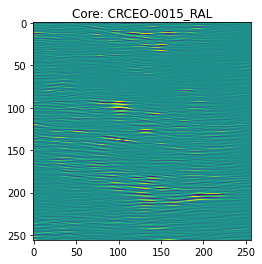

In [10]:
from matplotlib import pyplot as plt
from src.modeling.bert import TransformerEncoder
from src.modeling.optimizer_factory import configure_optimizers
from src.modeling.positional_embedding import GridPositionEmbedder2d

sample_core_batch = next(iter(core_dm.val_dataloader()))

plt.imshow(sample_core_batch[0][0][0][0])
plt.title(f'Core: {sample_core_batch.metadata["core_specifier"][0]}')

In [31]:
from dataclasses import dataclass

class PatchToCoreEmbedding(torch.nn.Module):
    def __init__(self, pool_mode='mean', hidden_size=512, patch_dropout=0.9): 
        super().__init__()
        self.transformer = TransformerEncoder(hidden_size, num_hidden_layers=12, intermediate_size=512, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
        self.pos_embedding = GridPositionEmbedder2d(hidden_size, (28, 46))
        
        if pool_mode == 'cls':
            self.cls_token = torch.nn.Parameter(
                torch.randn((1, hidden_size))
            )

        self.pool_mode = pool_mode
        self.patch_dropout = patch_dropout

    def forward(self, X, pos_x, pos_y): 
        pos_emb = self.pos_embedding(
            pos_x, pos_y
        )
        X = X + pos_emb
        
        if self.patch_dropout and self.training: 
            num_patches = len(X)
            perm = torch.randperm(X.size(0))
            k = int((1 - self.patch_dropout)*num_patches)
            idx = perm[:k]
            X = X[idx]

        if self.pool_mode == "cls":
            X = torch.concat([self.cls_token, X], dim=0)

        X = self.transformer(X.unsqueeze(0)).last_hidden_state[0]
        
        X = X[0] if self.pool_mode == 'cls' else X.mean(dim=0)
        return X

core_embedder = PatchToCoreEmbedding(hidden_size=512).to(cfg.device)
classifier = torch.nn.Linear(512, 2).to(cfg.device)
pca = torch.nn.Identity()

In [32]:
from src.modeling.optimizer_factory import (
    OptimizerConfig,
    configure_optimizers,
    SchedulerOptions,
)

params = [{"params": classifier.parameters()}, {"params": core_embedder.parameters()}]

N_EPOCHS = 200
ACC_GRAD_BATCHES = 64

#[opt], [sched] = configure_optimizers(
#    params,
#    OptimizerConfig(optim_algo="Adam", scheduler_options=SchedulerOptions(
#        warmup_epochs=10, 
#        max_epochs=N_EPOCHS
#    )),
#    len(core_dm.train_dataloader()) / ACC_GRAD_BATCHES,
#    N_EPOCHS,
#)
#sched = sched['scheduler']

opt = torch.optim.Adam(params, lr=5e-6)
feat_extractor_opt = torch.optim.Adam(pretrained_vicreg.parameters(), lr=1e-7)

In [33]:
# test forward

def log(dict): 
    print(dict)
    

def step(batch, batch_idx, opt_interval, log_loss_interval):
    
    def forward(batch):

        sample_core_batch = next(iter(core_dm.val_dataloader()))
        patch, pos, label, metadata = sample_core_batch
        pos = pos.to(cfg.device)[0]
        with torch.no_grad(): 
            feats = pretrained_vicreg.get_features(
                patch.to(cfg.device)[0]
            )
            feats = pca(feats)
        

        out = core_embedder(feats, pos[:, 0], pos[:, 2])
        pred = classifier(out)

        return pred

    label = batch[2][0].long().to(cfg.device)
    pred = forward(batch)
    loss = torch.nn.functional.cross_entropy(pred, label)
    
    if batch_idx % log_loss_interval == 0: 
        log({'loss': loss.item()})

    loss.backward()

    if batch_idx % opt_interval == 0: 
        opt.step()
        opt.zero_grad()

#for i in range(10): 
#    step(batch, 0, 1, 1)

In [34]:
import wandb
wandb.init(project='Exact_IPCAI', name='core_clf_all_centers_inner_dim_512_lr5e-6')

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▄▃▃▄▃▃▄▃▃▃▄▃▃▃▃▃▂▅▃▄▂▂▂▄▂█▃▆▄▂▂▃▄▆▁▅▂▁▂▄
lr,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_CRCEO_auroc,▁▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
test_CRCEO_macro_acc,▁▁▁▂▁▄▄▃▂▇▅▄▄▅▆▆▆▇▇▅▆▅▅▇█▇▆▅▆▇▇█▇▆██▆▆▇▇
test_JH_auroc,▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇
test_JH_macro_acc,▄▃▁▄▂▂▂▃▄▂▃▄▄▄▅▄▅▄▆▆▇▇▇▅▅▇▇█▆▇▇▇▆▇█▇▇▆▇▇
test_PCC_auroc,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████▇█
test_PCC_macro_acc,▁▂▂▄▃▂▁▃▂▂▁▅▃▃▅▂▅▄▅▃▆▅▅▅▆▆▇▅▆▇▇█▇▆▇█▆▇██
test_PMCC_auroc,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇████████████████▇█
test_PMCC_macro_acc,▂▁▁▃▁▃▄▃▁▃▄▄▅▆▅▅▅▄▆▆▇▇▇▇▅▇▇▆▇▇▇█▇▆█▇▆▆▆▇


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




In [41]:
train_loader = core_dm.train_dataloader()
#train_loader = list(islice(train_loader, 10))
val_loader = core_dm.val_dataloader()
test_loader = core_dm.test_dataloader()

def pre_compute_features(loader): 
    out = [] 
    for batch in tqdm(loader): 
        patch, *_ = batch
        patch = patch.to(cfg.device)[0]
        with torch.no_grad(): 
            feats = pretrained_vicreg.get_features(patch)
            feats = pca(feats)
        batch = feats, *_ 
        out.append(batch)
    return out
#
#val_loader = pre_compute_features(val_loader)
#test_loader = pre_compute_features(test_loader)
#train_loader_precomputed = pre_compute_features(train_loader)

In [42]:
from itertools import islice
import contextlib

ACC_GRAD_BATCHES = 100
LOSS_LOG_INTERVAL = 50
        
def log(dict): 
    wandb.log(dict)
    #print(dict)

_total_train_steps = 0

def train_loop(loader, epoch): 
    pretrained_vicreg.eval()
    core_embedder.train()
    should_train_feat_extractor = epoch > 100

    global _total_train_steps
    collector = ClassificationOutputCollector()
    core_embedder.train()

    for batch in tqdm(loader):

        patch, pos, label, metadata = batch
        patch = patch.to(cfg.device)[0]
        pos = pos.to(cfg.device)[0]
        label = label.to(cfg.device)[0].long()

        with torch.no_grad() if should_train_feat_extractor else contextlib.nullcontext(): 
            feats = pretrained_vicreg.get_features(patch)
            feats = pca(feats)

        embs = core_embedder(feats, pos[:, 0], pos[:, 2])
        logits = classifier(embs)
        loss = torch.nn.functional.cross_entropy(logits, label) / ACC_GRAD_BATCHES
        if _total_train_steps % LOSS_LOG_INTERVAL == 0:
            log({'loss': loss.item()})

        loss.backward()
        if _total_train_steps % ACC_GRAD_BATCHES == 0: 
            opt.step()
            opt.zero_grad()
            if sched: 
                sched.step()
                log({'lr': sched.get_last_lr()[-1]})
            if should_train_feat_extractor: 
                feat_extractor_opt.step()
                feat_extractor_opt.zero_grad()

        patch, pos, label, metadata = batch
        collector.collect_batch(
            {
                'preds': logits.unsqueeze(0).softmax(-1), 
                'labels': label.long(), 
                **metadata
            }
        )
        _total_train_steps += 1

    return compute_center_and_macro_metrics(collector.compute(), base_metrics)

def eval_loop(loader): 
    pretrained_vicreg.eval()
    core_embedder.eval()
    collector = ClassificationOutputCollector()
    core_embedder.eval()

    for batch in tqdm(loader):
        patch, pos, label, metadata = batch
        patch = patch.to(cfg.device)[0]
        pos = pos.to(cfg.device)[0]
        label = label.to(cfg.device)[0].long()

        with torch.no_grad(): 
            feats = pretrained_vicreg.get_features(patch)
            feats = pca(feats)
            embs = core_embedder(feats, pos[:, 0], pos[:, 2])
            logits = classifier(embs)
      
        patch, pos, label, metadata = batch
        collector.collect_batch(
            {
                'preds': logits.unsqueeze(0).softmax(-1), 
                'labels': label.long(), 
                **metadata
            }
        )

    return compute_center_and_macro_metrics(collector.compute(), base_metrics)

In [43]:
#loader = [batch for batch in train_loader][:50]

for epoch in range(200): 
    metrics = train_loop(train_loader, epoch)
    metrics = add_prefix(metrics, 'train')
    metrics['epoch'] = epoch
    log(metrics)
    metrics = eval_loop(val_loader)
    metrics = add_prefix(metrics, 'val')
    metrics['epoch'] = epoch
    wandb.log(metrics)
    metrics = eval_loop(test_loader)
    metrics = add_prefix(metrics, 'test')
    metrics['epoch'] = epoch
    wandb.log(metrics)


  0%|          | 0/978 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7ff676f008b0>
Traceback (most recent call last):
  File "/home/paulw/anaconda3/envs/exact/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
 23%|██▎       | 228/978 [00:17<00:39, 18.84it/s]